<a href="https://colab.research.google.com/github/neriiacopo/IAAC-II-CLIPStudies-Masterclass/blob/main/IAACII_CLIP_Studies_OpenVocabulary_Object_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### *La Maquina que ve @ ETSAM - November 2024*
**WHAT - Open Vocabulary object-detection with OWL-ViT**
*Iacopo Neri (iacopo.neri@uzh.ch) -- IAAC Faculty & MaCT Computational Lead (Spain) // Digital Visual Studies, University of Zurich (Switzerland)*

*Darìo Negueruela del Castillo (iacopo.neri@uzh.ch) -- Digital Visual Studies, University of Zurich (Switzerland)*

The following script takes extensive inspiration from the original [OWL-ViT-inference example](https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/zeroshot_object_detection_with_owlvit.ipynb)

# Import libraries

In [2]:
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install Pillow
!pip install matplotlib
!pip install opencv-python

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [5]:
import torch

# Use GPU if available
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [15]:
import cv2
import skimage
import numpy as np
from PIL import Image
import requests
from io import BytesIO

In [11]:
import matplotlib.pyplot as plt
from transformers.image_utils import ImageFeatureExtractionMixin

# Import Model

In [3]:
from transformers import OwlViTProcessor, OwlViTForObjectDetection

model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32")
processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.42k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/613M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/392 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

# General functions

In [42]:
def run_predictions(model, text_queries, image):
  # Process image and text inputs
  inputs = processor(text=text_queries, images=image, return_tensors="pt").to(device)

  # Set model in evaluation mode
  model = model.to(device)
  model.eval()

  # Get predictions
  with torch.no_grad():
    outputs = model(**inputs)

  return outputs

def get_results(model, image, outputs):
  mixin = ImageFeatureExtractionMixin()

  # Load example image
  image_size = model.config.vision_config.image_size
  image = mixin.resize(image, image_size)
  input_image = np.asarray(image).astype(np.float32) / 255.0

  # Get prediction logits
  logits = torch.max(outputs["logits"][0], dim=-1)
  scores = torch.sigmoid(logits.values).cpu().detach().numpy()

  # Get prediction labels and boundary boxes
  labels = logits.indices.cpu().detach().numpy()
  boxes = outputs["pred_boxes"][0].cpu().detach().numpy()

  return input_image, labels, boxes, scores


def plot_predictions(input_image, text_queries, scores, boxes, labels, threshold):
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.imshow(input_image, extent=(0, 1, 1, 0))
    ax.set_axis_off()

    for score, box, label in zip(scores, boxes, labels):
      if score < threshold:
        continue

      cx, cy, w, h = box
      ax.plot([cx-w/2, cx+w/2, cx+w/2, cx-w/2, cx-w/2],
              [cy-h/2, cy-h/2, cy+h/2, cy+h/2, cy-h/2], "r")
      ax.text(
          cx - w / 2,
          cy + h / 2 + 0.015,
          f"{text_queries[label]}: {score:1.2f}",
          ha="left",
          va="top",
          color="red",
          bbox={
              "facecolor": "white",
              "edgecolor": "red",
              "boxstyle": "square,pad=.3"
          })



# Object Detection

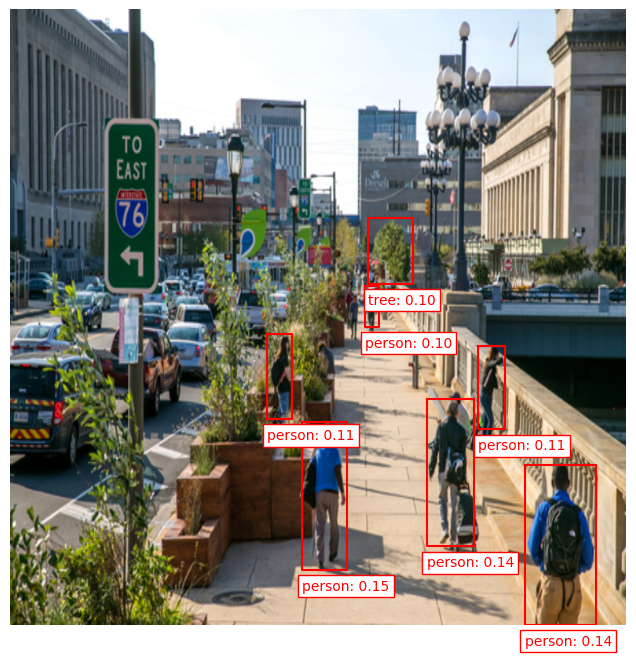

In [50]:
#@title Settings 🔬🎨

url = "https://www.universitycity.org/sites/default/files/Market_Street_Bridge-2.jpg" #@param {type:"string"}

#@markdown _to separate labels use_ /

input_lbls = "person/tree/signal/streetlamp" #@param {type:"string"}
#@markdown _reduce the threshold for less confident detections_

threshold = 0.1 #@param {type:"number"}


# Import data
response = requests.get(url)
image = Image.open(BytesIO(response.content))

# Preprocess inputs
text_queries = input_lbls.split("/")

# Run Prediction
outputs = run_predictions(model, text_queries, image)

# # Plot result
input_image, labels, boxes, scores = get_results(model, image, outputs)
plot_predictions(input_image, text_queries, scores, boxes, labels, threshold)